# Homework 3

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Matheus Raka Pradnyatama
* matheusraka@uchicago.edu

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import jinja2

from scipy.stats import norm
from functools import partial
from typing import Union, List
from sklearn.linear_model import LinearRegression

pd.options.display.float_format = "{:,.4f}".format

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

***

# 1. Modeling Volatility and VaR

## Data

Find the data file `spy_data.xlsx`.

* Use the returns on the S&P 500 (`SPY`) and 1-month T-bills (`^IRX`).

* Calculate the excess market returns, using the treasury rate as the risk-free rate.

In [22]:
filepath1 = '/Users/matheus/Desktop/finm-portfolio-2024/data/spy_data.xlsx'
data = pd.read_excel(filepath1, sheet_name='total returns').set_index('date').fillna(method = 'ffill')
data['excess_returns'] = data['SPY'] - data['^IRX'] 
rets = data['excess_returns']
data.head()

,SPY,^IRX,excess_returns
date,,,
1994-01-04,0.0040,0.0001,0.0039
1994-01-05,0.0020,0.0001,0.0019
1994-01-06,0.0000,0.0001,-0.0001
1994-01-07,0.0060,0.0001,0.0059
1994-01-10,0.0120,0.0001,0.0118


***

## 1.1 Historic VaR.
Starting at `Jan 2, 2001`, calculate the historic-based VaR, based on the expanding sample from the first date through `Dec 29, 2000`. 

Denote $\tilde{r}^{VaR, 0.05}_{t}$ as the estimate of the time-t VaR based on data through $t − 1$.

### Report
Report the items below, starting at , starting at `Jan 2, 2001`.

* Plot $\tilde{r}^{VaR, 0.05}_{t}$ over time.

* Report the frequency of periods in which $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t}$. Compare this to the quantile of $.05$.

* What drawbacks do you see in this historic VaR?

#### Note
By historic VaR, we mean simply taking the 5th quantile for the historic sample up to time $t − 1$. Of course, a sample size that is not a multiple of 100 will require some interpolation to get a 5th quantile. Your statistical package should handle this fine.

In [23]:
# Get the index number for Jan 2, 2001
date = '2001-01-02'
date_number = data.index.get_loc(date)
print(date_number)

1753


In [24]:
historic_VaR = rets.shift().expanding(min_periods = 1753).quantile(.05) #default shift is 1
data['SPY Historic VaR 5%'] = historic_VaR
reported_data = data.loc["2001-01-02":] # Start from January 2, 2001
reported_data.head()

,SPY,^IRX,excess_returns,SPY Historic VaR 5%
date,,,,
2001-01-02,-0.0181,0.0002,-0.0183,-0.0177
2001-01-03,0.0480,0.0002,0.0478,-0.0178
2001-01-04,-0.0108,0.0002,-0.0110,-0.0178
2001-01-05,-0.0326,0.0002,-0.0328,-0.0178
2001-01-08,0.0077,0.0002,0.0075,-0.0179


The frequency of returns below the VaR threshold is: 4.86%


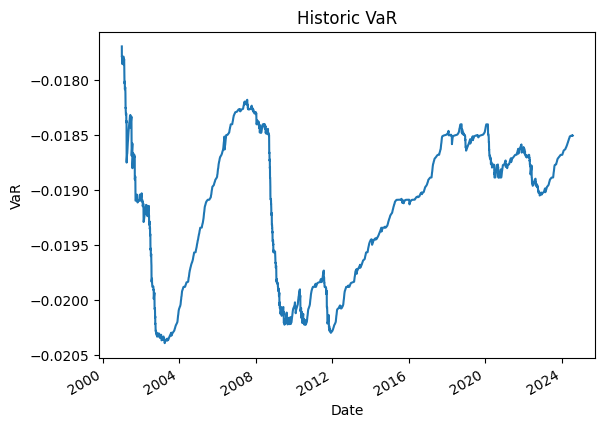

In [25]:
historic_VaR = rets.shift().expanding(min_periods = 1753).quantile(.05) #default shift is 1
historic_VaR.plot(title = 'Historic VaR', ylabel = 'VaR', xlabel = 'Date')

# The frequency of periods where the return is less than historic var
hit_ratio = sum(rets < historic_VaR)/len(historic_VaR.dropna())
print('The frequency of returns below the VaR threshold is: {:,.2%}'.format(hit_ratio))

In [26]:
hit_ratio_error = abs(hit_ratio / .05 - 1)
print(f"Hit Ratio: {hit_ratio:.2%}")
print(f"Hit Ratio Error: {hit_ratio_error:.2%}")

Hit Ratio: 4.86%
Hit Ratio Error: 2.82%


How good is my VaR?

Resonable... but it overestimates the tail risk of my asset/portfolio. We define how good our estimate is based on the hit ratio (frequency of returns below the threshold). $q$ is always your target Hit Ratio. If my $Hit Ratio < q$, my VaR estimate is overestimating risk. If my $Hit Ratio > q$ , my VaR estimate is underestimating the risk. Since here, q = 5% and the Hit Ratio is 4.86%, my VaR overestimates the tail risk of my asset/portfolio.

<b> Drawbacks of Historic VaR </b>

Backward Looking: Looks at only the historical data while estimating the losses in the future. Availability of sufficient and relevant data becomes a challenge.

Ghosting Effect: Equal weights on past observations that may never be relevant again. For example, low returns during 2008 (which may not be relevant anymore) are given the same weight as the most recent observations

Slow to React: Less weight on most recent observations. A recent significant loss still does not impact historical VaR because it has the same weight as the other observations

***

## 1.2 Volatility
We will calculate a time-series of volatility estimates using a few different methods. For each, we use $\sigma_t$ to denote our estimate of the time-t return volatility.

#### Expanding Series

$$
\sigma^2_{t,expanding} = \frac{1}{t-1}\sum_{\tau = 1}^{t-1}\tilde{r}^2_{\tau}
$$



#### Rolling Window

$$
\sigma^2_{t,rolling} = \frac{1}{m}\sum_{l = 1}^{m}\tilde{r}^2_{t-l}
$$

Use $m=$`252`.


#### Exponentially Weighted Moving Average (EWMA)

Feel free to calculate the EWMA using the following recursion,
$$
\sigma^2_{t, EWMA} = \theta \sigma^2_{t-1, EWMA} + (1-\theta)\tilde{r}^2_{t-1}
$$

Rather than estimating $\theta$, simply use $\theta$ = 0.94, and initialize with 
$$\sigma_{t_0} = \frac{0.20}{\sqrt{252}}$$

### Report
Report the items below, starting at , starting at `Jan 2, 2001`.

* For each of these three methods, plot $\sigma_t$. (Plot the vol, not the variance.)

* For each method, calculate the 5th percentile, 1-day-ahead VaR. We use a slight simplification of the normal VaR formula, by dropping $\mu$ from that formula, and rounding the normal distribution z-score to -1.65.
$$\tilde{r}^{VaR, 0.05}_{t} = −1.65 \sigma_t$$

* For each of these vol-based VaR estimates, calculate the frequency of periods in which $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t}$

* Compare and contrast your results among each other and relative to the historic method in the previous problem.

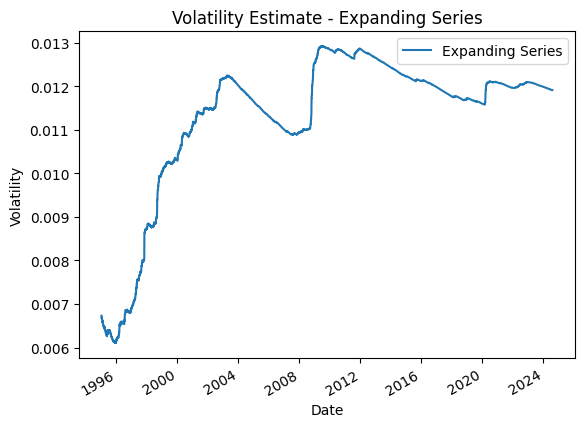

In [27]:
# Expanding Series
expanding_window = np.sqrt((rets**2).expanding(252).mean().shift()) #default shift is 1
expanding_df = pd.DataFrame({'Expanding Series': expanding_window})

# Reporting only starting in January 2, 2001
expanding_report = expanding_df#.loc['2001-01-02':]
expanding_report.plot(title = 'Volatility Estimate - Expanding Series',ylabel = 'Volatility', xlabel = 'Date')
plt.show()

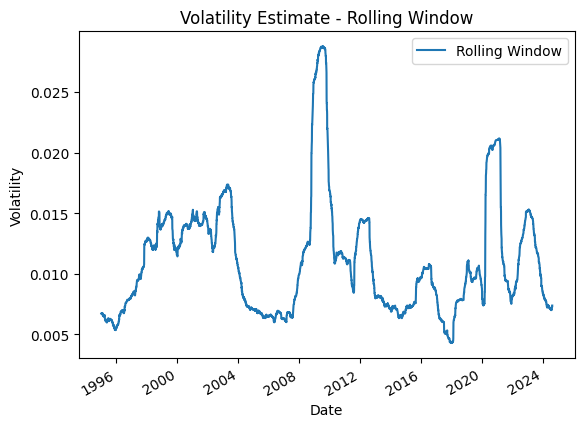

In [28]:
# Rolling Window
rolling_window = np.sqrt((rets**2).rolling(252).mean().shift())
rolling_df = pd.DataFrame({'Rolling Window': rolling_window})

# Reporting only starting in January 2, 2001
rolling_report = rolling_df#.loc['2001-01-02':]
rolling_report.plot(title = 'Volatility Estimate - Rolling Window',ylabel = 'Volatility', xlabel = 'Date')
plt.show()

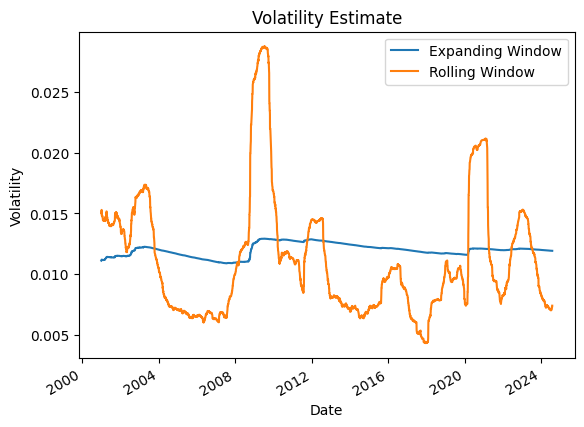

In [29]:
expanding_window = np.sqrt((rets**2).expanding(252).mean().shift())
rolling_window = np.sqrt((rets**2).rolling(252).mean().shift())

std = pd.DataFrame({'Expanding Window': expanding_window, 'Rolling Window': rolling_window})

# Reporting only starting in January 2, 2001
std_report = std.loc['2001-01-02':]
std_report.plot(title = 'Volatility Estimate',ylabel = 'Volatility', xlabel = 'Date')
plt.show()

In [30]:
# EWMA
std = pd.DataFrame({'Expanding Window': expanding_window, 'Rolling Window': rolling_window})

theta = 0.94
sigma1 = 0.2/np.sqrt(252)

avail_dates = std.dropna().index

ewma = pd.Series(0, index = avail_dates, name = 'EWMA')
ewma[0] = sigma1

for i, ind in enumerate(avail_dates[1:], 1):
    ewma[i] = np.sqrt(ewma[i-1]**2 * theta + (1-theta) * rets.loc[ind]**2)

std = pd.concat([std, ewma], axis = 1)

# Select rows starting from '2001-01-02'
df_from_jan2 = std.loc['2001-01-02':]

df_from_jan2.dropna()

,Expanding Window,Rolling Window,EWMA
date,,,
2001-01-02,0.0111,0.0150,0.0171
2001-01-03,0.0111,0.0151,0.0203
2001-01-04,0.0112,0.0152,0.0198
2001-01-05,0.0112,0.0152,0.0208
2001-01-08,0.0112,0.0153,0.0203
...,...,...,...
2024-07-29,0.0119,0.0073,0.0082
2024-07-30,0.0119,0.0073,0.0081
2024-07-31,0.0119,0.0073,0.0087


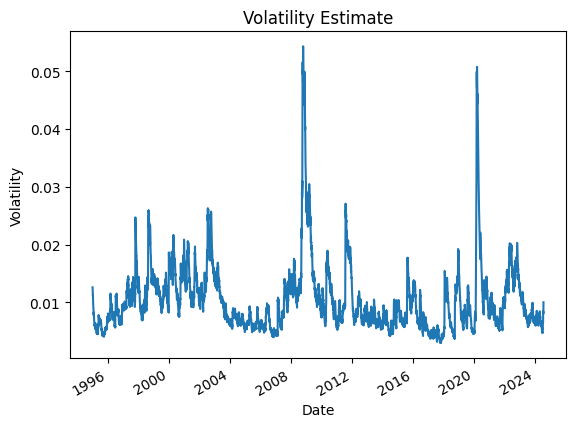

In [31]:
# EWMA 
# Reporting only starting in January 2, 2001
ewma_report = ewma#.loc['2001-01-02':]
ewma_report.plot(title = 'Volatility Estimate',ylabel = 'Volatility', xlabel = 'Date')
plt.show()

* For each of these three methods, plot $\sigma_t$. (Plot the vol, not the variance.)

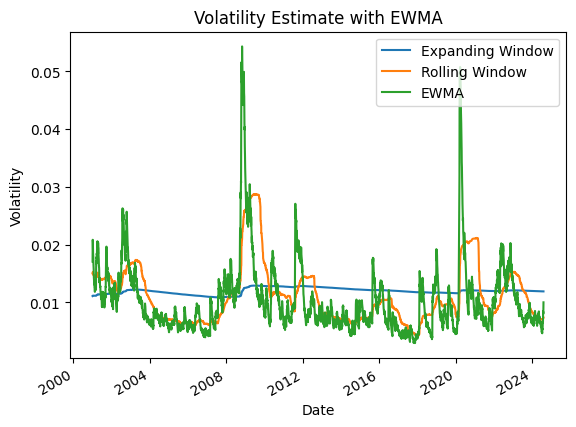

In [32]:
std_filtered = std[std.index >= '2001-01-02']
std_filtered.plot(title = 'Volatility Estimate with EWMA',ylabel = 'Volatility', xlabel = 'Date')
plt.show()

For each method, calculate the 5th percentile, 1-day-ahead VaR. We use a slight simplification of the normal VaR formula, by dropping 
 from that formula, and rounding the normal distribution z-score to -1.65.

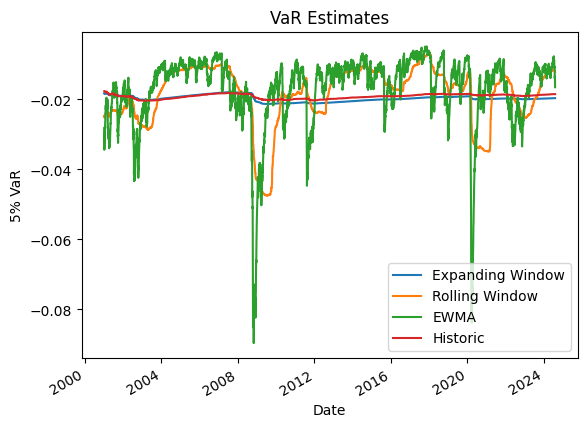

In [33]:
VaR = -1.65 * std
VaR['Historic'] = historic_VaR
# Plot only from January 2, 2001
var_filtered = VaR[VaR.index >= '2001-01-02']
var_filtered.plot(title = 'VaR Estimates', ylabel = '5% VaR', xlabel = 'Date')
plt.show()

For each of these vol-based VaR estimates, calculate the frequency of periods in which 

Compare and contrast your results among each other and relative to the historic method in the previous problem.

In [34]:
# Comparison between two pandas series using apply
# This only works when the index of two series are the same

var_temp = VaR.dropna()
frequency =  var_temp.apply(lambda x: rets.loc[var_temp.index] < x).mean().to_frame('Frequency')
frequency.style.format('{:,.2%}')

,Frequency
Expanding Window,4.61%
Rolling Window,5.28%
EWMA,5.03%
Historic,4.86%


EWMA is a more accurate estimate compared to other methods. It allows us to consider every data point up until the one we want to predict (characteristic of the expanding series method) but it gives more weight (importance) to recent data set (a characteristic of the rolling window method). EWMA is a compromise between the expanding series and rolling window method.

***

## 1.3 CVaR
Re-do the previous two problems, but this time calculating CVaR instead of VaR, (still for $q =$ `.05`.) 

<Axes: title={'center': 'CVaR estimates'}, xlabel='Date', ylabel='5% CVaR'>

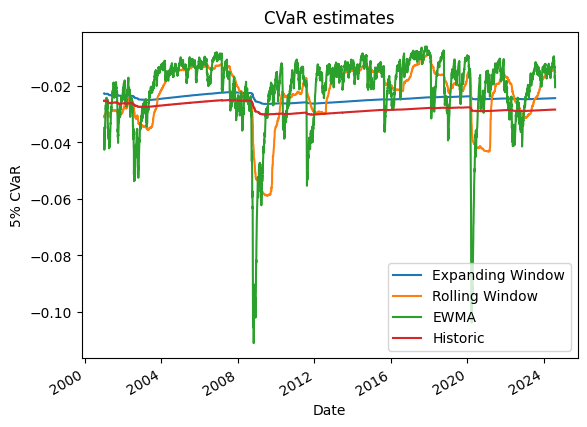

In [35]:
CVaR = -norm.pdf(1.65) / 0.05 * std

# Historic CVaR, we use min_periods = 1753
CVaR['Historic'] = rets.expanding(min_periods = 1753).apply(lambda x: x[x < x.quantile(.05)].mean())


CVaR_filtered = CVaR[CVaR.index >= '2001-01-02']

CVaR_filtered.plot(title = 'CVaR estimates', ylabel = '5% CVaR', xlabel = 'Date')

In [36]:
# Comparison between two pandas series using apply
# This only works when the index of two series are the same

cvar_temp = CVaR.dropna()
frequency =  cvar_temp.apply(lambda x: rets.loc[cvar_temp.index] < x).mean().to_frame('Frequency')
frequency.style.format('{:,.2%}')

,Frequency
Expanding Window,2.58%
Rolling Window,3.32%
EWMA,2.21%
Historic,1.96%


***

## 1.4 GARCH

#### EXTRA: Not Submitted, not covered in Midterm 1

Re-do the VaR and CVaR calculations using a normal model with volatility calculated from a GARCH(1,1).

To estimate GARCH(1,1), try using the ARCH package in Python. The default estimation implementation is fine. You should be familiar with EWMA and GARCH from the August Review.